In [18]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import math
import typing
import torch
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import torch.nn.functional as F
from torch_geometric_temporal.nn.attention.stgcn import TemporalConv
import torch.utils.data as data
#from stgcn_base import STGCN
#from novel_stgcn import STGCN as novelSTGCN
from DCRNN import RecurrentGCN
from LSTM import TrafficLSTM
from LSTM import evaluate as evaluate_LSTM

torch.manual_seed(200)
torch.cuda.manual_seed(200)

In [2]:
def get_dataset():
    """
    Function to load METR-LA dataset
    Output:
    dataset: a StaticTemporalSignal object of the METR-LA dataset
    A: adjacency matrix of the dataset
    z_score_mean: the mean value during z-score normalization
    z_score_std: the standard deviation value during z-score normalization
    """
    loader = METRLADatasetLoader()
    dataset = loader.get_dataset()
    
    z_score_mean = dataset.meanValues
    z_score_std = dataset.stdValues
    
    A = np.load(os.getcwd()+'\\data\\adj_mat.npy')
    
    return dataset, A, z_score_mean, z_score_std

def get_test_data(dataset):
    """
    Outputs test data
    """
    _, test_dataset = temporal_signal_split(dataset, train_ratio = 0.8)
    
    X_test = torch.Tensor(np.array(test_dataset.features))
    X_test = X_test.permute(0, 1, 3, 2)
    y_test = torch.Tensor(np.array(test_dataset.targets))
    
    return X_test, y_test

def get_normalized_adj(A):
    """
    Returns the degree normalized adjacency matrix.
    """
    A = A + np.diag(np.ones(A.shape[0], dtype=np.float32))
    D = np.array(np.sum(A, axis=1)).reshape((-1,))
    D[D <= 10e-5] = 10e-5    # Prevent infs
    diag = np.reciprocal(np.sqrt(D))
    A_wave = np.multiply(np.multiply(diag.reshape((-1, 1)), A),
                         diag.reshape((1, -1)))
    return A_wave

def test_STGCN(X_test, y_test, A, path, model_version):
    num_timesteps_input = 12
    num_timesteps_output = 12
    if model_version == "base":
        stgcn_model = STGCN(A.shape[0], X_test.shape[3], num_timesteps_input, num_timesteps_output).to(device=device)
    elif model_version == "novel":
        stgcn_model = novelSTGCN(A.shape[0], X_test.shape[3], num_timesteps_input, num_timesteps_output).to(device=device)
    stgcn_model.load_state_dict(torch.load(path))
    test_input = X_test
    test_target = y_test
    test_maes = []
    # Set the network to evaluation mode
    stgcn_model.eval()

    # Create empty lists to store predictions and true labels
    predictions = []
    true_labels = []

    # Loop through the test set and make predictions
    with torch.no_grad():
        for i in range(test_input.shape[0]):
            # Get the input and target for this sample
            input_i = test_input[i:i+1, ...].to(device=device)
            target_i = test_target[i:i+1, ...].to(device=device)

            # Make the prediction
            prediction_i = stgcn_model(A, input_i)

            # Convert the prediction and target to numpy arrays and unnormalize them
            prediction_i = prediction_i.detach().cpu().numpy() * stds[0] + means[0]
            target_i = target_i.detach().cpu().numpy() * stds[0] + means[0]

            mae = np.mean(np.absolute(prediction_i - target_i))

            # Append the prediction and target to the lists
            predictions.append(prediction_i)
            true_labels.append(target_i)
            test_maes.append(mae)

    # Concatenate the lists of predictions and true labels into numpy arrays
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    test_mae = sum(test_maes) / len(test_maes)
    print("12-step test MAE of the {} STGCN model is = {}".format(model_version, test_mae))
    plt.plot(true_labels[2350:3000,100,1], label="Actual")
    plt.plot(predictions[2350:3000,100,1], label="{} STGCN Prediction".format(model_version))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel("Speed (MPH)")
    plt.title("True vs Predicted speed for sensor 100")
    plt.show()

In [3]:
dataset, A, means, stds = get_dataset()
X_test, y_test = get_test_data(dataset)
A = get_normalized_adj(A)
A = torch.from_numpy(A)
print("Shape of A is = ", A.size())

Data was normalized via Z-Score method with mean = [53.59967    0.4982691] and std = [20.209862    0.28815305]
Shape of A is =  torch.Size([207, 207])


In [4]:
print("Shape of X_test is {} and y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_test is torch.Size([6850, 207, 12, 2]) and y_test is torch.Size([6850, 207, 12])


In [5]:
assert torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A = A.to(device=device)

num_timesteps_input = 12
num_timesteps_output = 12

12-step test MAE of the base STGCN model is = 5.847362856673498


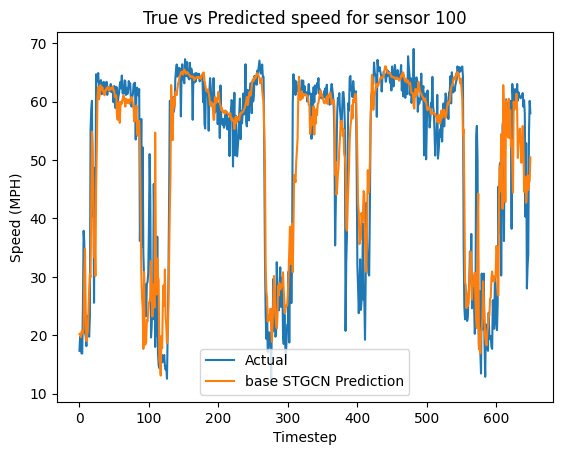

In [6]:
test_STGCN(X_test, y_test, A, 'stgcn/STGCN.pt', 'base')

12-step test MAE of the novel STGCN model is = 5.758616913052371


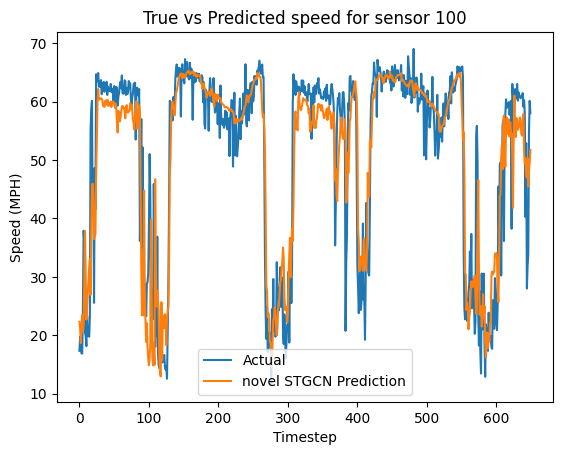

In [7]:
test_STGCN(X_test, y_test, A, 'stgcn/newSTGCN.pt', 'novel')

In [12]:
def get_test_dcrnn():
    DEVICE = torch.device('cuda') 
    batch_size = 64
    loader = METRLADatasetLoader()

    dataset = loader.get_dataset()

    train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio = 0.8)
    test_input = np.array(test_dataset.features) # (, 207, 2, 12)
    test_target = np.array(test_dataset.targets) # (, 207, 12)
    test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_dataset, test_loader

def test_dcrnn(model_path):
    train_dataset, test_loader = get_test_dcrnn()
    device = torch.device('cuda') 
    # Loading the graph once because it's a static graph
    for snapshot in train_dataset:
        static_edge_index = snapshot.edge_index.to(device)
        static_edge_attr = snapshot.edge_attr.to(device)
        break
    model = RecurrentGCN(node_features = 12, hidden_size=64)
    model = model.to(device)
    model = torch.load(model_path)
    model.eval()
    loss_fn2 = F.l1_loss
    step = 0
    # Store for analysis
    total_loss = []
    predictions = []
    labels_list = []
    with torch.no_grad():
        for encoder_inputs, labels in test_loader:
            # Get model predictions
            y_hat = model(encoder_inputs, static_edge_index, static_edge_attr)
            # reshape back to BxNxT
            y_hat = y_hat.reshape((labels.shape))
            # undo z-score
            #print(labels.shape)
            #print(y_hat.shape)
            mean = [53.59967, 0.4982691]
            std = [20.209862, 0.28815305]
            labels = labels*std[0] + mean[0]
            y_hat = y_hat*std[0] + mean[0]
            # Mean squared error
            #loss = loss_fn(y_hat, labels)
            # Mean absolute error
            loss = loss_fn2(y_hat, labels)
            total_loss.append(loss.item())
            # Store for analysis below
            predictions.append(y_hat.cpu())
            labels_list.append(labels.cpu())
    predictions = torch.cat(predictions)
    labels_list = torch.cat(labels_list)
    pred = predictions.numpy()
    lab = labels_list.numpy()
    print("Test MAE of DCRNN model is: {:.4f}".format(sum(total_loss)/len(total_loss)))
    plt.plot(lab[2350:3000, 100, 2], label = 'Actual')
    plt.plot(pred[2350:3000, 100, 2], label = 'DCRNN Prediction')
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel("Speed (MPH)")
    plt.show()

In [26]:
test_dcrnn("DCRNN/DCRNN")

FileNotFoundError: [Errno 2] No such file or directory: 'DCRNN/DCRNN'

In [22]:
def create_dataset_LSTM(dataset, normalize):
    data_x = np.array(dataset.features)
    # just get speed
    data_x = data_x[:,:,0,:]
    N, S, T = data_x.shape
    #print(N,S,T)
    #train_data_x = train_data_x.reshape((N, S*T))
    data_y = np.array(dataset.targets)
    #train_data_y = train_data_y[:,:,timestep_to_predict].reshape(N, S, 1)
    #train_data_y = train_data_y.reshape((N, S*T))
    
    x = torch.tensor(data_x).swapaxes(1,2)
    y = torch.tensor(data_y).swapaxes(1,2)
    max_speed = torch.max(x)
    #print("max: ", max_speed)
    min_speed = torch.min(x)
    if(normalize == True):
        x = (x - min_speed)/(max_speed - min_speed)
        y = (y - min_speed)/(max_speed - min_speed)
    #x_train = torch.tensor(train_data_x)
    #y_train = torch.tensor(train_data_y)
    #print(x.shape)
    #print(y.shape)
    return data.TensorDataset(x, y), max_speed, min_speed

def get_dataset_LSTM():
    loader = METRLADatasetLoader()
    dataset = loader.get_dataset()
    train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio = 0.8)
    test_dataset, max_speed, min_speed = create_dataset_LSTM(test_dataset, normalize = False)
    test_loader = data.DataLoader(test_dataset, batch_size = 8, drop_last=True)
    return test_loader

def test_LSTM(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Hyper parameters
    input_size = 207
    hidden_size = 512
    model = TrafficLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=3, sequence_len=12)
    loss_func = F.mse_loss
    loss_func2 = F.l1_loss
    model = model.to(device)
    model = torch.load(model_path)
    test_loader = get_dataset_LSTM()
    pred, lab, rmse, mae = evaluate_LSTM(model, test_loader, loss_func, loss_func2, device)
    print("Test MAE of LSTM model is: {:.4f}".format(mae))
    pred = torch.cat(pred)
    lab = torch.cat(lab)
    pred = pred.numpy()
    lab = lab.numpy()
    plt.plot(lab[2350:3000, 100, 2], label = 'Actual')
    plt.plot(pred[2350:3000, 100, 2], label = 'LSTM Prediction')
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel("Speed (MPH)")
    plt.show()



In [25]:
test_LSTM('/LSTM/LSTM')

FileNotFoundError: [Errno 2] No such file or directory: '/LSTM/LSTM'